# Imports

In [25]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import pyrealsense2 as rs
import tkinter as tk

from PIL import Image
from scipy.interpolate import splprep, splev

# Class: Color Selector with GUI

In [26]:
class ColorSelector:
    def __init__(self):
        # Create the main window
        self.root = tk.Tk()

        # Set the window title and size
        self.root.title("Color Selector")
        self.root.geometry("340x170")

        # Center the window on the screen
        self.root.eval('tk::PlaceWindow %s center' % self.root.winfo_toplevel())

        # Create four buttons with different background colors and styles
        self.red_button = tk.Button(self.root, text="Red", bg="red", command=self.select_red, font=("Helvetica", 16), width=10, height=2)
        self.orange_button = tk.Button(self.root, text="Orange", bg="orange", command=self.select_orange, font=("Helvetica", 16), width=10, height=2)
        self.green_button = tk.Button(self.root, text="Green", bg="green", command=self.select_green, font=("Helvetica", 16), width=10, height=2)
        self.yellow_button = tk.Button(self.root, text="Yellow", bg="yellow", command=self.select_yellow, font=("Helvetica", 16), width=10, height=2)

        # Pack the buttons into the window using the grid layout manager
        self.red_button.grid(row=0, column=0, padx=10, pady=10)
        self.orange_button.grid(row=0, column=1, padx=10, pady=10)
        self.green_button.grid(row=1, column=0, padx=10, pady=10)
        self.yellow_button.grid(row=1, column=1, padx=10, pady=10)

    # Method to select the "red" color
    def select_red(self):
        self.root.destroy()
        self.color = "red"

    # Method to select the "orange" color
    def select_orange(self):
        self.root.destroy()
        self.color = "orange"

    # Method to select the "green" color
    def select_green(self):
        self.root.destroy()
        self.color = "green"

    # Method to select the "yellow" color
    def select_yellow(self):
        self.root.destroy()
        self.color = "yellow"

    # Method to show the color selector window and return the selected color
    def get_color(self):
        self.color = None
        self.root.mainloop()
        return self.color

# Function: Search desired color type and return x,y pixel coordinates

In [27]:
def detection(color):

    "This function detects the biggest area of a color in the image and returns the center of the area in pixel coordinates."

    # define the lower and upper boundaries of the colors in the HSV color space
    if color=="red":
        lower_value = np.array([155, 85, 0], dtype = "uint8") 
        upper_value= np.array([179, 255, 255], dtype = "uint8")

    if color=="yellow":
        lower_value = np.array([21, 87, 99], dtype = "uint8") 
        upper_value= np.array([31, 255, 255], dtype = "uint8")

    if color=="orange":
        lower_value = np.array([0, 76, 0], dtype = "uint8") 
        upper_value= np.array([17, 255, 255], dtype = "uint8")

    if color=="green":
        lower_value = np.array([35, 31, 0], dtype = "uint8") 
        upper_value= np.array([93, 255, 255], dtype = "uint8")
    
    # Configure color streams
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    # Start streaming
    pipeline.start(config)

    # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()

    # Convert images to numpy arrays
    color_image = np.asanyarray(color_frame.get_data())

    hsv = cv2.cvtColor(color_image, cv2.COLOR_BGR2HSV)    # convert to HSV
    mask0 = cv2.inRange(hsv, lower_value, upper_value)  # mask for color

    kernel = np.ones((15,15),np.uint8)  # 15x15 kernel for morphological transformation
    opening = cv2.morphologyEx(mask0, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((5,5),np.uint8)  # 20x20 kernel for morphological transformation
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours
    c = max(contours, key = cv2.contourArea) # find the biggest contour (c) by the area

    # find the center of the contour
    M = cv2.moments(c)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    # find the spline
    tck, u = splprep(c[:,0,:].T, s=0.0)    
    u_new = np.linspace(u.min(), u.max(), 1000) 
    x_new, y_new = splev(u_new, tck, der=0)

    # plot the spline
    plt.figure(figsize=(8, 8))
    plt.imshow(closing, cmap='gray')
    plt.plot(x_new, y_new, 'r')
    plt.plot(cx, cy, 'bo') 
    plt.show()
    
    print("Center of biggest Area in (x,y): (",cx, ",",cy,")")   # print the center of the contour

    # show original image with contour of biggest area
    image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.plot(x_new, y_new, 'r')
    plt.plot(cx, cy, 'bo') 
    plt.show()

    return cx, cy

# Calling the function

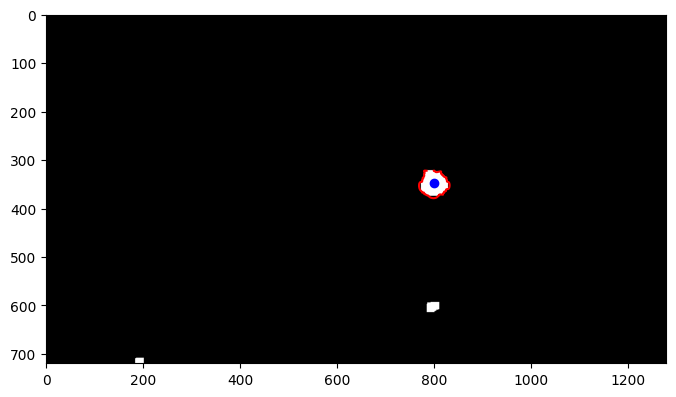

Center of biggest Area in (x,y): ( 800 , 348 )


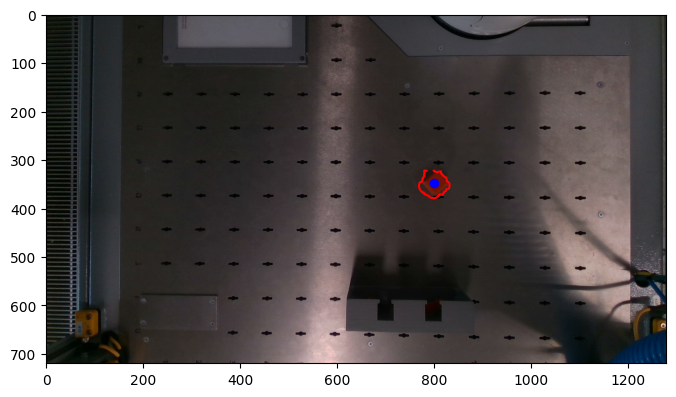

In [28]:
color_selector = ColorSelector()
selected_color = color_selector.get_color()

cx, cy = detection(selected_color)

# From given pixel coordinates, calculate x,y,z coordinates in camera frame

In [29]:
# Initialize RealSense pipeline and get depth sensor intrinsics
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
profile = pipeline.start(config)

depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
intrinsics = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()

# Read a depth frame and get a pixel coordinate
frames = pipeline.wait_for_frames()
depth_frame = frames.get_depth_frame()
depth_image = np.asanyarray(depth_frame.get_data())
pixel = (cx, cy)  # example pixel coordinate

# Deproject pixel to 3D point in camera coordinates
depth_value = depth_image[pixel[1], pixel[0]]
point_3d = rs.rs2_deproject_pixel_to_point(intrinsics, pixel, depth_value)

print(point_3d[0]/1000, point_3d[1]/1000, point_3d[2]/1000)

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

# Wait for a coherent pair of frames: depth and color
frames = pipeline.wait_for_frames()
color_frame = frames.get_color_frame()

# Convert images to numpy arrays
color_image = np.asanyarray(color_frame.get_data())

# Draw a red circle on the color image at pixel (100, 200)
cv2.circle(color_image, (cx, cy), 10, (0, 0, 255), 2)

# Show the color image with the red circle
cv2.imshow("Color Image", color_image)
cv2.waitKey(0)

# Stop streaming
pipeline.stop()
cv2.destroyAllWindows()


0.11785384368896484 -0.006023372650146484 0.645
